### Genome-wide perturb-seq

This notebook prepares a dataset from a [paper with giant Perturb-seq experiments](https://www.cell.com/cell/fulltext/S0092-8674(22)00597-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867422005979%3Fshowall%3Dtrue) applied to all expressed genes or all essential genes.

Here we tidy the dataset and carry out a simple exploration in scanpy.

We start from a pseudo-bulk version where all cells are added together within each perturbation. 

This study does knockdown, not knockout. 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.stats import spearmanr as spearmanr
from IPython.display import display, HTML
from collections import Counter

# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

import anndata
import os, sys
import itertools as it
from scipy.stats import spearmanr, pearsonr, rankdata, f_oneway
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#      visualization settings
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# I prefer to specify the working directory explicitly.
os.chdir("/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/perturbation_data")

# Universal
geneAnnotationPath = "../accessory_data/gencode.v35.annotation.gtf.gz"       # Downloaded from https://www.gencodegenes.org/human/release_35.html
humanTFPath =  "../accessory_data/humanTFs.csv"                              # Downloaded from http://humantfs.ccbr.utoronto.ca/download.php
humanEpiPath = "../accessory_data/epiList.csv"                               # Downloaded from https://epifactors.autosome.org/description 
cellcycleGenePath = "../accessory_data/regev_lab_cell_cycle_genes.txt"

# Replogle3 Specific
dataset_name = "replogle4"
perturbEffectTFOnlyPath = "setup/replogle4TFOnly.csv"                         # a path to store temp file
perturbEffectFullTranscriptomePath = "setup/replogle4FullTranscriptome.csv"   # a path to store temp file

### Load expression data & set up cell metadata

In [3]:
expression_quantified = sc.read_h5ad(f"not_ready/{dataset_name}/rpe1_raw_bulk_01.h5ad")
expression_quantified.var_names = ingestion.convert_ens_to_symbol(
    expression_quantified.var_names, 
    gtf=geneAnnotationPath,
    strip_version=True,
)
expression_quantified

AnnData object with n_obs × n_vars = 2679 × 8749
    obs: 'UMI_count_unfiltered', 'num_cells_unfiltered', 'num_cells_filtered', 'control_expr', 'fold_expr', 'pct_expr', 'core_control', 'mean_leverage_score', 'std_leverage_score', 'energy_test_p_value', 'anderson_darling_counts', 'mann_whitney_counts', 'z_gemgroup_UMI', 'mitopercent', 'TE_ratio', 'cnv_score_z'
    var: 'gene_name', 'mean', 'std', 'cv', 'in_matrix', 'gini', 'clean_mean', 'clean_std', 'clean_cv'

### Fill `perturbation` & `is_control` and find TF's

In [4]:
human_tfs = pd.read_csv(humanTFPath)
human_tfs = human_tfs.loc[human_tfs["Is TF?"]=="Yes",:]
expression_quantified.obs["gene_symbol"] = [s.split("_")[1] for s in expression_quantified.obs.index]
expression_quantified.obs["is_tf"] = expression_quantified.obs["gene_symbol"].isin(human_tfs["HGNC symbol"])
expression_quantified.obs["ensembl_id"] = [s.split("_")[3] for s in expression_quantified.obs.index]
expression_quantified.obs["is_control"]     = expression_quantified.obs["gene_symbol"].str.contains("non")
expression_quantified.obs["is_control_int"] = expression_quantified.obs["gene_symbol"].str.contains("non").astype("int")
expression_quantified.obs["perturbation"] = expression_quantified.obs["gene_symbol"]
controls = expression_quantified.obs.query("is_control")["perturbation"]
print("controls")
print(controls)
expression_quantified.obs["is_tf"].value_counts()
expression_quantified.raw = expression_quantified.copy()

controls
gene_transcript
10755_non-targeting_non-targeting_non-targeting    non-targeting
10756_non-targeting_non-targeting_non-targeting    non-targeting
10758_non-targeting_non-targeting_non-targeting    non-targeting
10759_non-targeting_non-targeting_non-targeting    non-targeting
10764_non-targeting_non-targeting_non-targeting    non-targeting
                                                       ...      
11315_non-targeting_non-targeting_non-targeting    non-targeting
11321_non-targeting_non-targeting_non-targeting    non-targeting
11322_non-targeting_non-targeting_non-targeting    non-targeting
11324_non-targeting_non-targeting_non-targeting    non-targeting
11327_non-targeting_non-targeting_non-targeting    non-targeting
Name: perturbation, Length: 130, dtype: object


### Normalization

In [5]:
pseudobulk = expression_quantified.copy()
pseudobulk.raw = pseudobulk
pseudobulk.X = ingestion.deseq2Normalization(pseudobulk.X.T).T

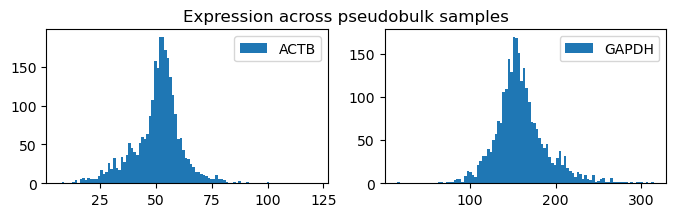

In [6]:
""" Sanity check: expression for house keeping genes are relatively stable """
fig, axes = plt.subplots(1, 2, figsize=(8,2))
axes[0].hist(pseudobulk.raw.X[:, [idx for idx, n in enumerate(pseudobulk.raw.var.index) if n.upper() == 'ACTB' ]], bins=100, label="ACTB" )
axes[1].hist(pseudobulk.raw.X[:, [idx for idx, n in enumerate(pseudobulk.raw.var.index) if n.upper() == 'GAPDH']], bins=100, label="GAPDH")
axes[0].legend()
axes[1].legend()
plt.suptitle("Expression across pseudobulk samples")
plt.show()

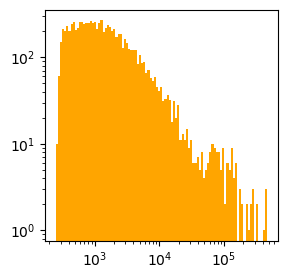

In [7]:
plt.figure(figsize=(3,3))
logbins = np.geomspace(
    pseudobulk.raw.X.sum(axis=0).min(),                    
    pseudobulk.raw.X.sum(axis=0).max(), 
    100)
plt.hist(pseudobulk.raw.X.sum(axis=0), 
         bins=logbins, 
         log=True, 
         color="orange")
plt.xscale('log')
plt.show()

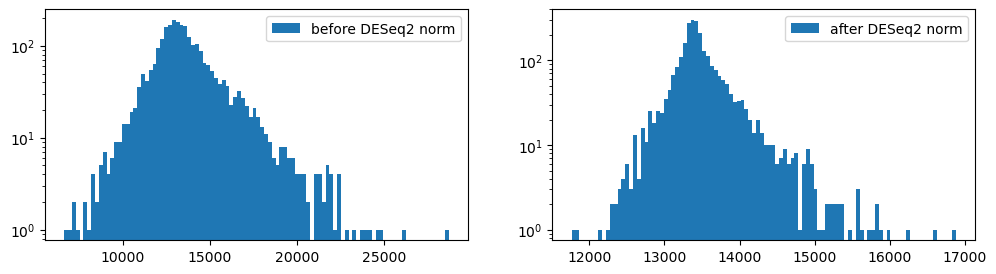

In [8]:
""" The sum of gene expression before and after normalization """
fig, axes = plt.subplots(1, 2, figsize=(12,3))
axes[0].hist(
    pseudobulk.raw.X.sum(axis=1), 
    bins=100, 
    log=True, 
    label="before DESeq2 norm")
axes[1].hist(
    pseudobulk.X.sum(axis=1), 
    bins=100, 
    log=True, 
    label="after DESeq2 norm")
axes[0].legend()
axes[1].legend()
plt.show()

UMI_count_unfiltered  num_cells_unfiltered  \
gene_transcript                                                           
33_ABCF1_P1_ENSG00000204574          16280.749023                    68   
34_ABCF1_P2_ENSG00000204574          13163.969727                    99   

                             num_cells_filtered  control_expr  fold_expr  \
gene_transcript                                                            
33_ABCF1_P1_ENSG00000204574                66.0      1.213154   0.078765   
34_ABCF1_P2_ENSG00000204574                91.0      1.213154   1.097758   

                             pct_expr  core_control  mean_leverage_score  \
gene_transcript                                                            
33_ABCF1_P1_ENSG00000204574 -0.921235         False             2.369154   
34_ABCF1_P2_ENSG00000204574  0.097758         False             0.446237   

                             std_leverage_score  energy_test_p_value  ...  \
gene_transcript                                                       ...   
33_ABCF1_P1_ENSG00000204574            1.092980              0.00010  ...   
34_ABCF1_P2_ENSG00000204574            0.768222              0.70403  ...   

                             z_gemgroup_UMI  mitopercent  TE_ratio  \
gene_transcript                                                      
33_ABCF1_P1_ENSG00000204574        0.893517     0.036937  0.003978   
34_ABCF1_P2_ENSG00000204574        0.229386     0.061825  0.005257   

                             cnv_score_z  gene_symbol  is_tf       ensembl_id  \
gene_transcript                                                                 
33_ABCF1_P1_ENSG00000204574     1.574195        ABCF1  False  ENSG00000204574   
34_ABCF1_P2_ENSG00000204574    -0.673615        ABCF1  False  ENSG00000204574   

                             is_control is_control_int  perturbation  
gene_transcript                                                       
33_ABCF1_P1_ENSG00000204574       False              0         ABCF1  
34_ABCF1_P2_ENSG00000204574       False              0         ABCF1  

[2 rows x 22 columns]

(8748,) (8748,)


SpearmanrResult(correlation=-0.005550249339240618, pvalue=0.6037267364753549)

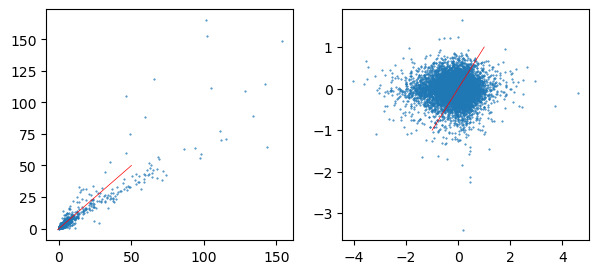

In [9]:
""" Check an exmaple (correlation at expression scale and at logFC scale) """

TFBePerturb = 'ABCF1'
display(pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].obs)
expr1 = pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[0,:]
expr2 = pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[1,:]

controlExpr  = pseudobulk[pseudobulk.obs.is_control, :].X
c1 = np.median(controlExpr.copy(), axis=0)

fig, axes = plt.subplots(1,2,figsize=(7,3))
logFC1 = np.log2(pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[0,:]/c1)
logFC2 = np.log2(pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[1,:]/c1)
validGeneEntry = np.isfinite(logFC1) & np.isfinite(logFC2)
logFC1 = logFC1[validGeneEntry]
logFC2 = logFC2[validGeneEntry]
print(logFC1.shape, logFC2.shape)
axes[0].scatter(expr1 , expr2 , s=0.2)
axes[0].plot(np.linspace(-1,50,50), np.linspace(-1,50,50), color='red', lw=0.5)
axes[1].scatter(logFC1, logFC2, s=0.2)
axes[1].plot(np.linspace(-1,1,50), np.linspace(-1,1,50), color='red', lw=0.5)
spearmanr(logFC1, logFC2)

### Consistency w/ Perturbation Direction

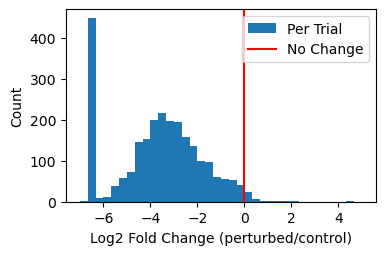

Counter({'No': 35, 'Yes': 2453, 'NA': 191})

In [10]:
# If verbose is set to True, display disconcordant trials and their controls

# Using the fold_expr field it stored in .obs 
# For perturbations where fold_expr = 0, some
# pct_expr = -1, denoting a knockout;
# others are nan, denoting lack of data or control run
fc = pseudobulk.obs.fold_expr.copy()
fc[pseudobulk.obs.pct_expr == -1] = 1e-2  # knockout
logFC = np.log2(fc)
logFC[np.isnan(logFC)] = -999             # control or no data

# Visualize the CRISPRi performance
validLogFC = logFC[logFC != -999]
rangeMin = np.floor(np.min(validLogFC))
rangeMax = np.ceil (np.max(validLogFC))
plt.figure(figsize=(4,2.5))
plt.hist(validLogFC, 
         bins=np.linspace(rangeMin, 
                          rangeMax, 
                          int((rangeMax-rangeMin)*3+1)), 
         label="Per Trial")
plt.axvline(0, 0, 1, color='red', label="No Change")
plt.xlabel("Log2 Fold Change (perturbed/control)")
plt.ylabel("Count")
plt.legend()
plt.show()

# Label knockdown outcome
status = np.full(logFC.shape[0], "NA", dtype=object)
status[(logFC <  0) & (logFC != -999)] = "Yes"
status[(logFC >= 0)] = "No"

pseudobulk.obs["consistentW/Perturbation"] = status
pseudobulk.obs["logFC"] = logFC
Counter(status)

### Consistency across replications

In [11]:
print(f"Of {pseudobulk.n_obs} observations, {len(set(pseudobulk.obs.perturbation))} unique perturbagen")

Of 2679 observations, 2394 unique perturbagen


[812 832] ABCF1 1
[2223 2255] ACIN1 2
[253 254 258] ADAM10 3
[299 305] ADAT3 4
[912 914] AP2M1 5
[1316 1320] ARPC2 6
[1323 1324] ARPC3 7
[2091 2092] BCAR1 8
[2119 2121] BCL2L1 9
[2324 2326] BOP1 10
[39 40] C1orf109 11
[174 177 179] C7orf26 12
[222 223] CACNB3 13
[246 247] CCDC130 14
[250 251] CCDC144NL 15
[256 257 259] CCDC6 16
[266 267] CCND1 17
[270 271] CCNK 18
[316 317] CENPA 19
[334 335] CFDP1 20
[361 362] CKAP5 21
[367 368 370] CLOCK 22
[402 403] COPG1 23
[410 411] COPZ1 24
[443 444] CSH2 25
[490 491] DDB1 26
[500 501] DDX19B 27
[511 512] DDX46 28
[517 518] DDX54 29
[532 533] DHODH 30
[553 554] DNAJA1 31
[572 573] DPH1 32
[595 596] DYNLRB1 33
[607 608] EEF2 34
[642 643] EIF4G2 35
[646 647] EIF5 36
[659 660] EMC3 37
[674 675 676 677 678] EPS8L1 38
[685 686] ERVW-1 39
[687 688] ESF1 40
[690 691] ESPN 41
[719 720 721] FAM136A 42
[742 743 744] FBXO42 43
[764 765] FOLR3 44
[781 782] GAPDH 45
[828 829] GON4L 46
[841 842] GRB2 47
[884 885] HAUS7 48
[901 902] HIRA 49
[927 928] HMGB1 50
[

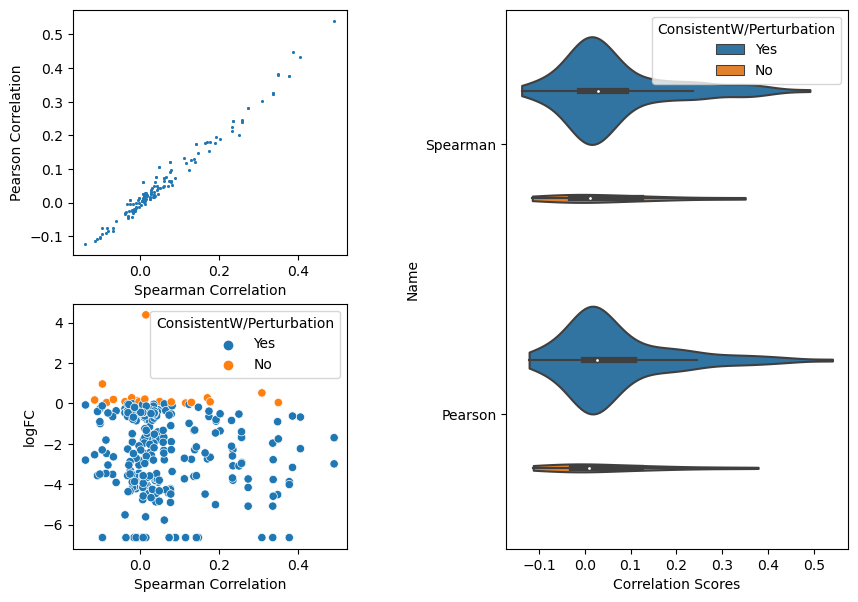

In [12]:
# !! A very small proportion of perturbations have replications
correlations = ingestion.computeCorrelation(pseudobulk, verbose=True)
pseudobulk.obs["spearmanCorr"] = correlations[0]
pseudobulk.obs[ "pearsonCorr"] = correlations[1]

### Perturbation Effect

In [13]:
"""
Downloaded from http://humantfs.ccbr.utoronto.ca/download.php """
TFList = pd.read_csv(humanTFPath, index_col=0).iloc[:, [1,3]]
TFDict = dict([tuple(i) for i in TFList.to_numpy().tolist() if i[1] == 'Yes'])

"""
Downloaded from https://epifactors.autosome.org/description """
EpiList = pd.read_csv(humanEpiPath, index_col=0).iloc[:, [0,14]]
EpiDict = dict([tuple(i) for i in EpiList.to_numpy().tolist()])

In [14]:
""" If want to look at bigness on TF only """
TFVar = [i for i,p in enumerate(pseudobulk.var.index) if p in TFDict or p in EpiDict]
pseudobulkTFOnly = pseudobulk[:, TFVar].copy()
ingestion.quantifyEffect(adata=pseudobulkTFOnly, 
                         fname=perturbEffectTFOnlyPath, 
                         group=None, 
                         diffExprFC=False, 
                         prefix="TFOnly", 
                         withDEG=False, 
                         withMI=False)

177
0 AAAS -999.0 0.23108969628810883 0.16965505480766296 10.513350486755371 -999.0
1 AAMP -999.0 0.7536674737930298 0.5583653450012207 33.15769577026367 -999.0
2 AAR2 -999.0 0.6746965646743774 0.5606476068496704 27.865131378173828 -999.0
3 AARS -999.0 0.5909478664398193 0.436352014541626 26.3243465423584 -999.0
4 AARS2 -999.0 0.221261128783226 0.16292166709899902 9.89448070526123 -999.0
5 AASDHPPT -999.0 0.2791959047317505 0.2159658819437027 12.324668884277344 -999.0
6 AATF -999.0 0.5776183605194092 0.4187537729740143 26.591320037841797 -999.0
7 ABCB10 -999.0 0.5521172285079956 0.40745222568511963 24.82892417907715 -999.0
8 ABCB7 -999.0 0.5339845418930054 0.37850087881088257 25.39289093017578 -999.0
9 ABCE1 -999.0 0.5659212470054626 0.4720788598060608 24.320119857788086 -999.0
10 ABCF1 -999.0 0.2703113555908203 0.20502439141273499 12.156044006347656 -999.0
11 ABCG1 -999.0 0.22736750543117523 0.1698351800441742 10.3081636428833 -999.0
12 ABHD11 -999.0 0.33630791306495667 0.256814330816

In [15]:
ingestion.quantifyEffect(adata=pseudobulk, 
                         fname=perturbEffectFullTranscriptomePath, 
                         group=None,
                         diffExprFC=False, 
                         prefix="",
                         withDEG=False, 
                         withMI=False)

listOfMetrics = ["DEG", "MI", "logFCMean", "logFCNorm2", "logFCMedian"]
for m in listOfMetrics:
    pseudobulk.obs[f"TFOnly{m}"] = pseudobulkTFOnly.obs[f"TFOnly{m}"]

1922
0 AAAS -999.0 0.22098591923713684 0.1566634625196457 29.465330123901367 -999.0
1 AAMP -999.0 0.6904999613761902 0.516213059425354 86.23820495605469 -999.0
2 AAR2 -999.0 0.6291018724441528 0.47665563225746155 76.51862335205078 -999.0
3 AARS -999.0 0.5653605461120605 0.4248925447463989 71.99394989013672 -999.0
4 AARS2 -999.0 0.21885712444782257 0.1580401062965393 28.73674201965332 -999.0
5 AASDHPPT -999.0 0.2822732627391815 0.2045767903327942 37.54030227661133 -999.0
6 AATF -999.0 0.5626332759857178 0.4075658917427063 73.36835479736328 -999.0
7 ABCB10 -999.0 0.5164521932601929 0.3768552839756012 66.69872283935547 -999.0
8 ABCB7 -999.0 0.5004345178604126 0.361413836479187 66.27603149414062 -999.0
9 ABCE1 -999.0 0.5406183004379272 0.4343552589416504 66.31446838378906 -999.0
10 ABCF1 -999.0 0.25529181957244873 0.19103211164474487 32.67890548706055 -999.0
11 ABCG1 -999.0 0.2275753915309906 0.16647587716579437 30.0012264251709 -999.0
12 ABHD11 -999.0 0.316613107919693 0.23481640219688416

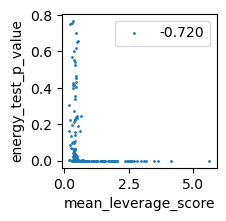

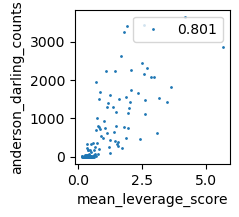

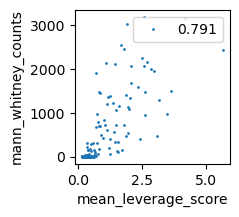

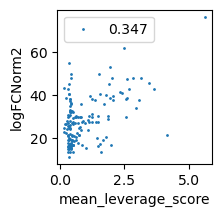

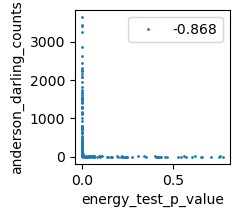

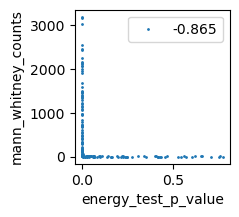

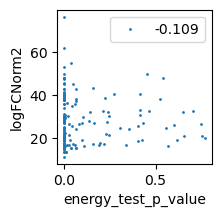

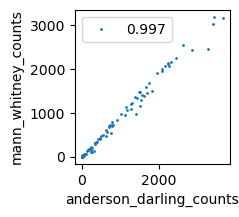

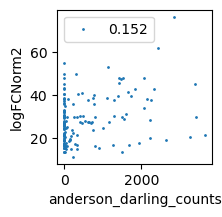

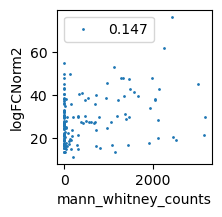

In [16]:
metricOfInterest = ["mean_leverage_score", 'energy_test_p_value', 'anderson_darling_counts', 
                    'mann_whitney_counts', 'logFCNorm2']
ingestion.checkPerturbationEffectMetricCorrelation(pseudobulk, metrics=metricOfInterest)

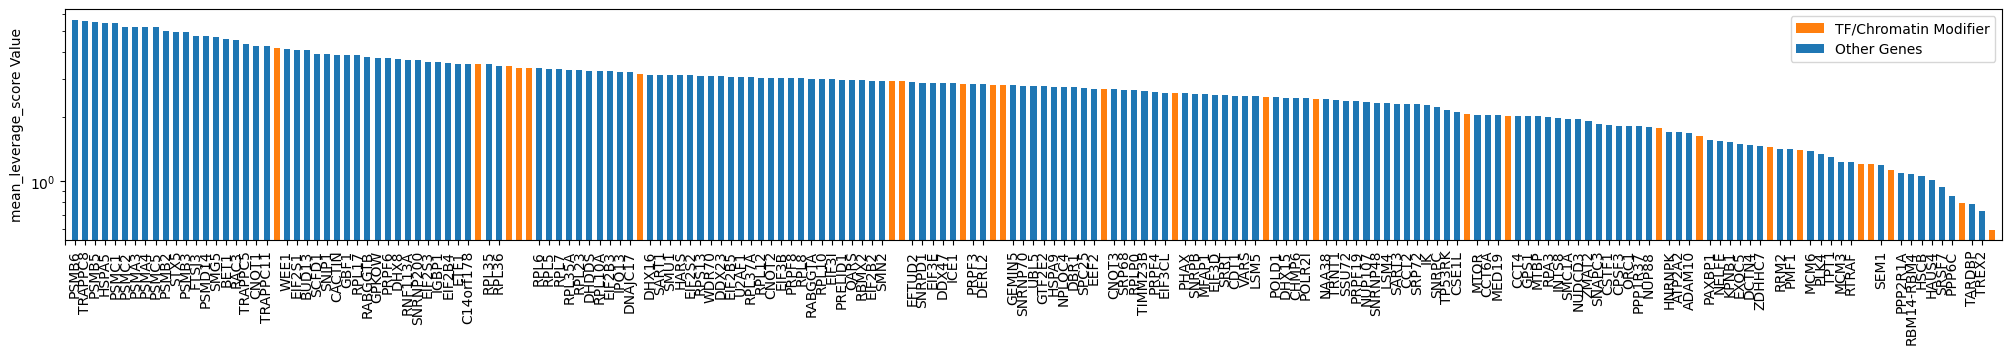

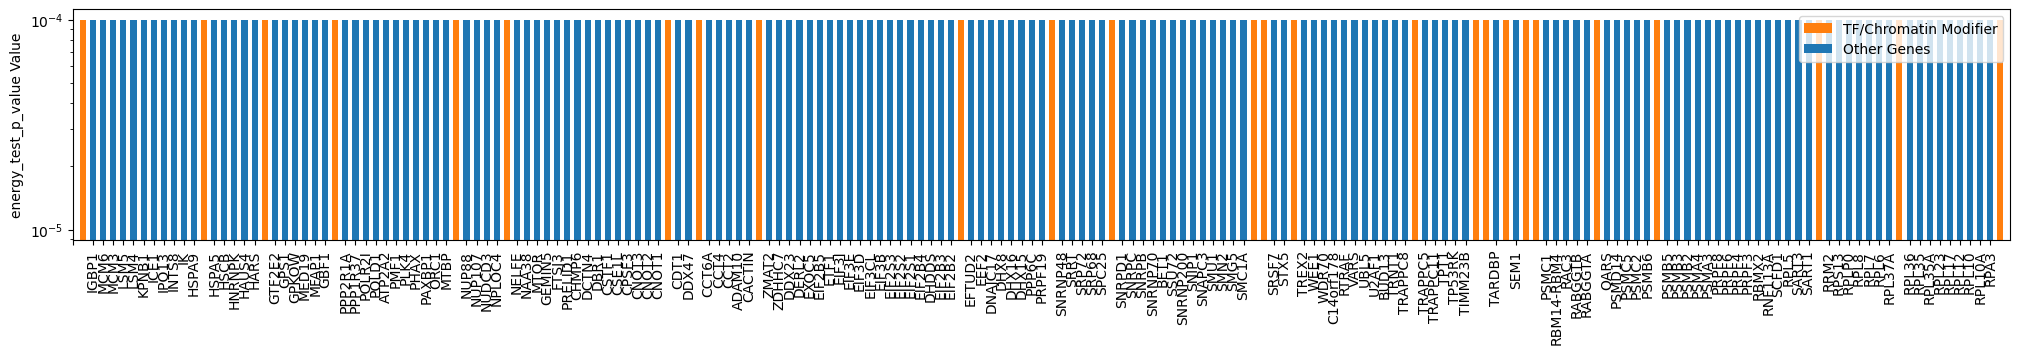

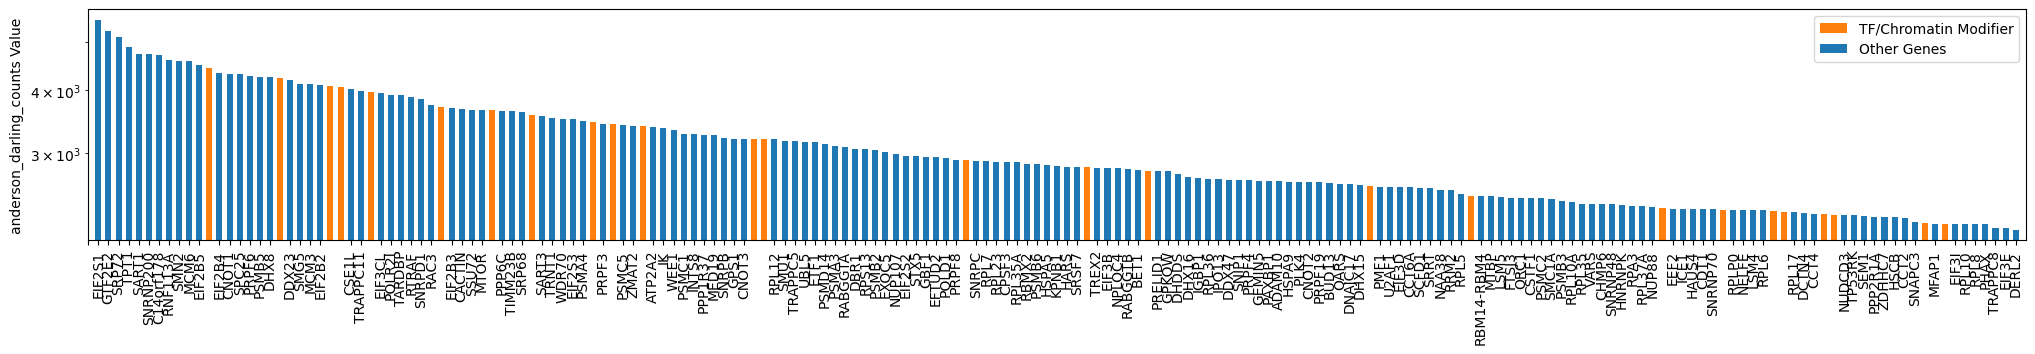

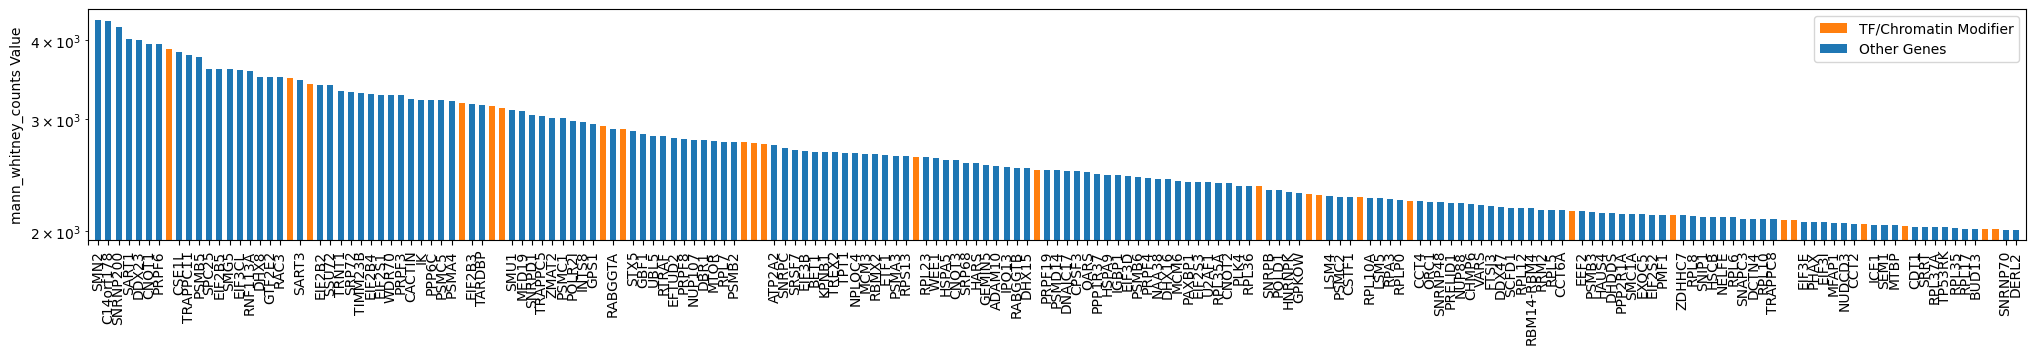

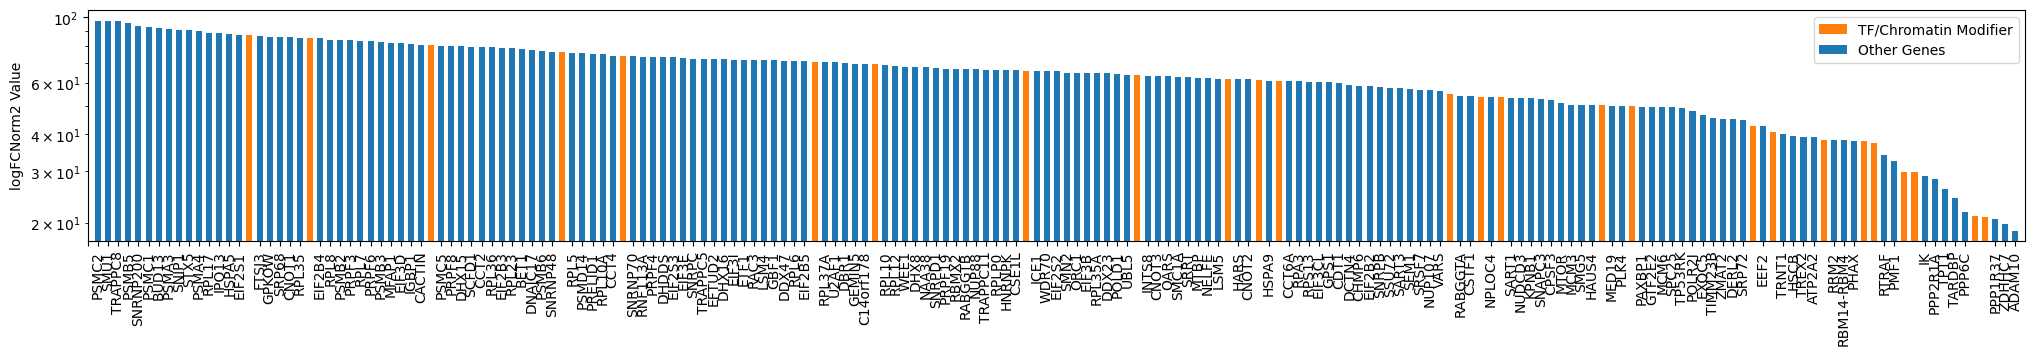

In [17]:
# Unable to look at everything
# Thus, look only at perturbation that results in more than 1000 DEGs
ingestion.visualizePerturbationEffect(
    pseudobulk[pseudobulk.obs.mann_whitney_counts > 2000], 
    metrics=metricOfInterest, 
    TFDict=TFDict, 
    EpiDict=EpiDict
)

In [18]:
for idx, p in enumerate(sorted(set([(i,j) for i,j in pseudobulk.obs[['perturbation', 'logFCNorm2']].to_numpy()]), key=lambda x: x[1])):
    print(idx, p)

0 ('non-targeting', -999.0)
1 ('GAB2', 9.673791885375977)
2 ('TFAM', 9.693987846374512)
3 ('MRPL35', 9.958057403564453)
4 ('TWF1', 10.767278671264648)
5 ('KRT17', 11.112771987915039)
6 ('SLC1A5', 11.212300300598145)
7 ('NBPF12', 11.40694522857666)
8 ('MRPL36', 11.535066604614258)
9 ('ANAPC15', 11.540019989013672)
10 ('HSD17B10', 11.92123031616211)
11 ('GFM1', 12.189247131347656)
12 ('MYBL2', 12.754487037658691)
13 ('SSBP3', 13.252516746520996)
14 ('EPS8L1', 13.372761726379395)
15 ('BCL2L1', 14.66269302368164)
16 ('FBXO42', 14.765198707580566)
17 ('CCDC6', 15.066296577453613)
18 ('DDX19B', 15.177724838256836)
19 ('ZNF718', 15.183364868164062)
20 ('CENPT', 15.194350242614746)
21 ('DDX19A', 15.203083992004395)
22 ('ZFP69B', 15.423118591308594)
23 ('RHOQ', 15.448753356933594)
24 ('HSD17B12', 15.466106414794922)
25 ('PRODH', 15.522493362426758)
26 ('DNM1', 15.731757164001465)
27 ('TMEM242', 15.943622589111328)
28 ('SRSF11', 16.124391555786133)
29 ('CSH2', 16.200164794921875)
30 ('BTF3L4', 1

2679 number of points are plotted


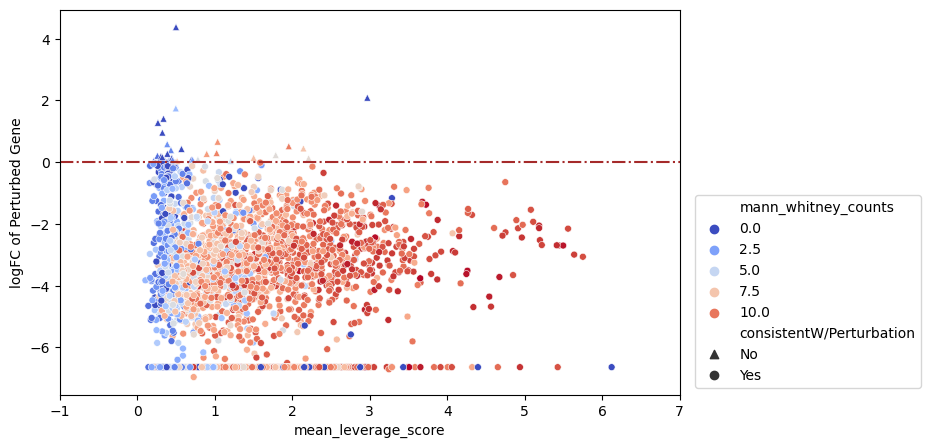

In [19]:
temp = pseudobulk.copy()

""" If you wish to see the magnitude of perturbation effect more clearer,
    i.e. a smoother gradient of the color shift, feel free to uncomment
    the line below, which takes the log of the mann_whitney_counts """
temp.obs['mann_whitney_counts'] = np.log2(temp.obs['mann_whitney_counts']+1)

ingestion.visualizePerturbationMetadata(temp, 
                                        x="mean_leverage_score", 
                                        y="logFC", 
                                        style="consistentW/Perturbation", 
                                        hue="mann_whitney_counts", 
                                        markers=['^', 'o'],
                                        xlim=[-1, 7], 
                                        s=25)

2488


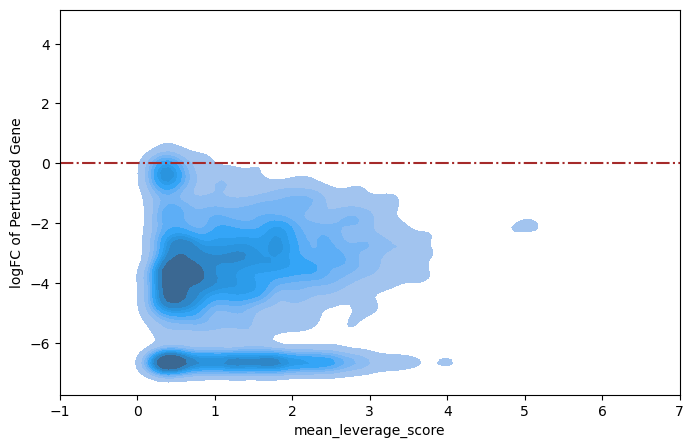

In [20]:
x = "mean_leverage_score"
y = "logFC"
style = "consistentW/Perturbation"
hue = "mann_whitney_counts"
markers = ['^', 'o']
xlim = [-1, 7]
s = 25
adata = pseudobulk

validMat = (adata.obs[x] != -999) & (adata.obs[y] != -999) & (~adata.obs.is_control)
print(sum(validMat))
plt.figure(figsize=(8, 5))


g =sns.kdeplot(data=adata.obs[validMat], 
               x=x,
               y=y,
               palette=sns.color_palette("coolwarm", as_cmap=True), 
               fill=True, 
               gridsize=100, 
               bw_adjust=0.5)
plt.axhline(0, 0, 1, linestyle='-.', color='brown')
plt.ylabel(f"{y} of Perturbed Gene")
plt.xlim(xlim)
plt.show()

### Basic EDA

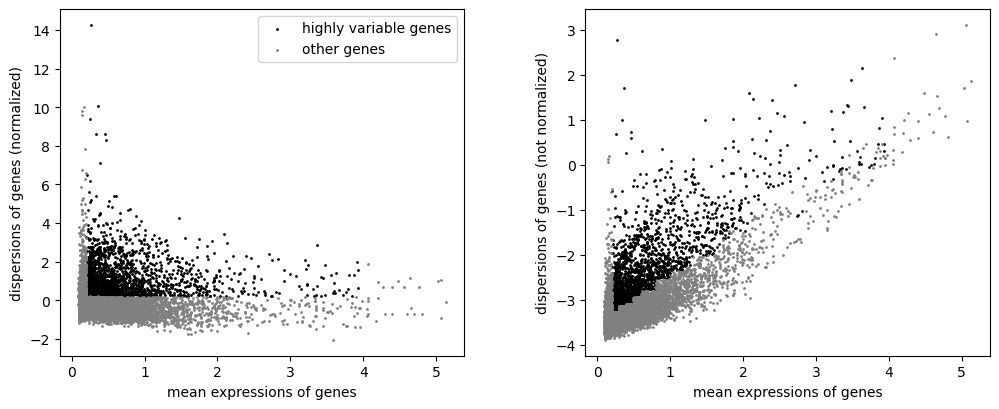

In [21]:
sc.pp.log1p(pseudobulk)
sc.pp.highly_variable_genes(pseudobulk, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(pseudobulk)
with warnings.catch_warnings():
    sc.tl.pca(pseudobulk, n_comps=100)
sc.pp.neighbors(pseudobulk)
sc.tl.umap(pseudobulk)
clusterResolutions = []
sc.tl.leiden(pseudobulk)

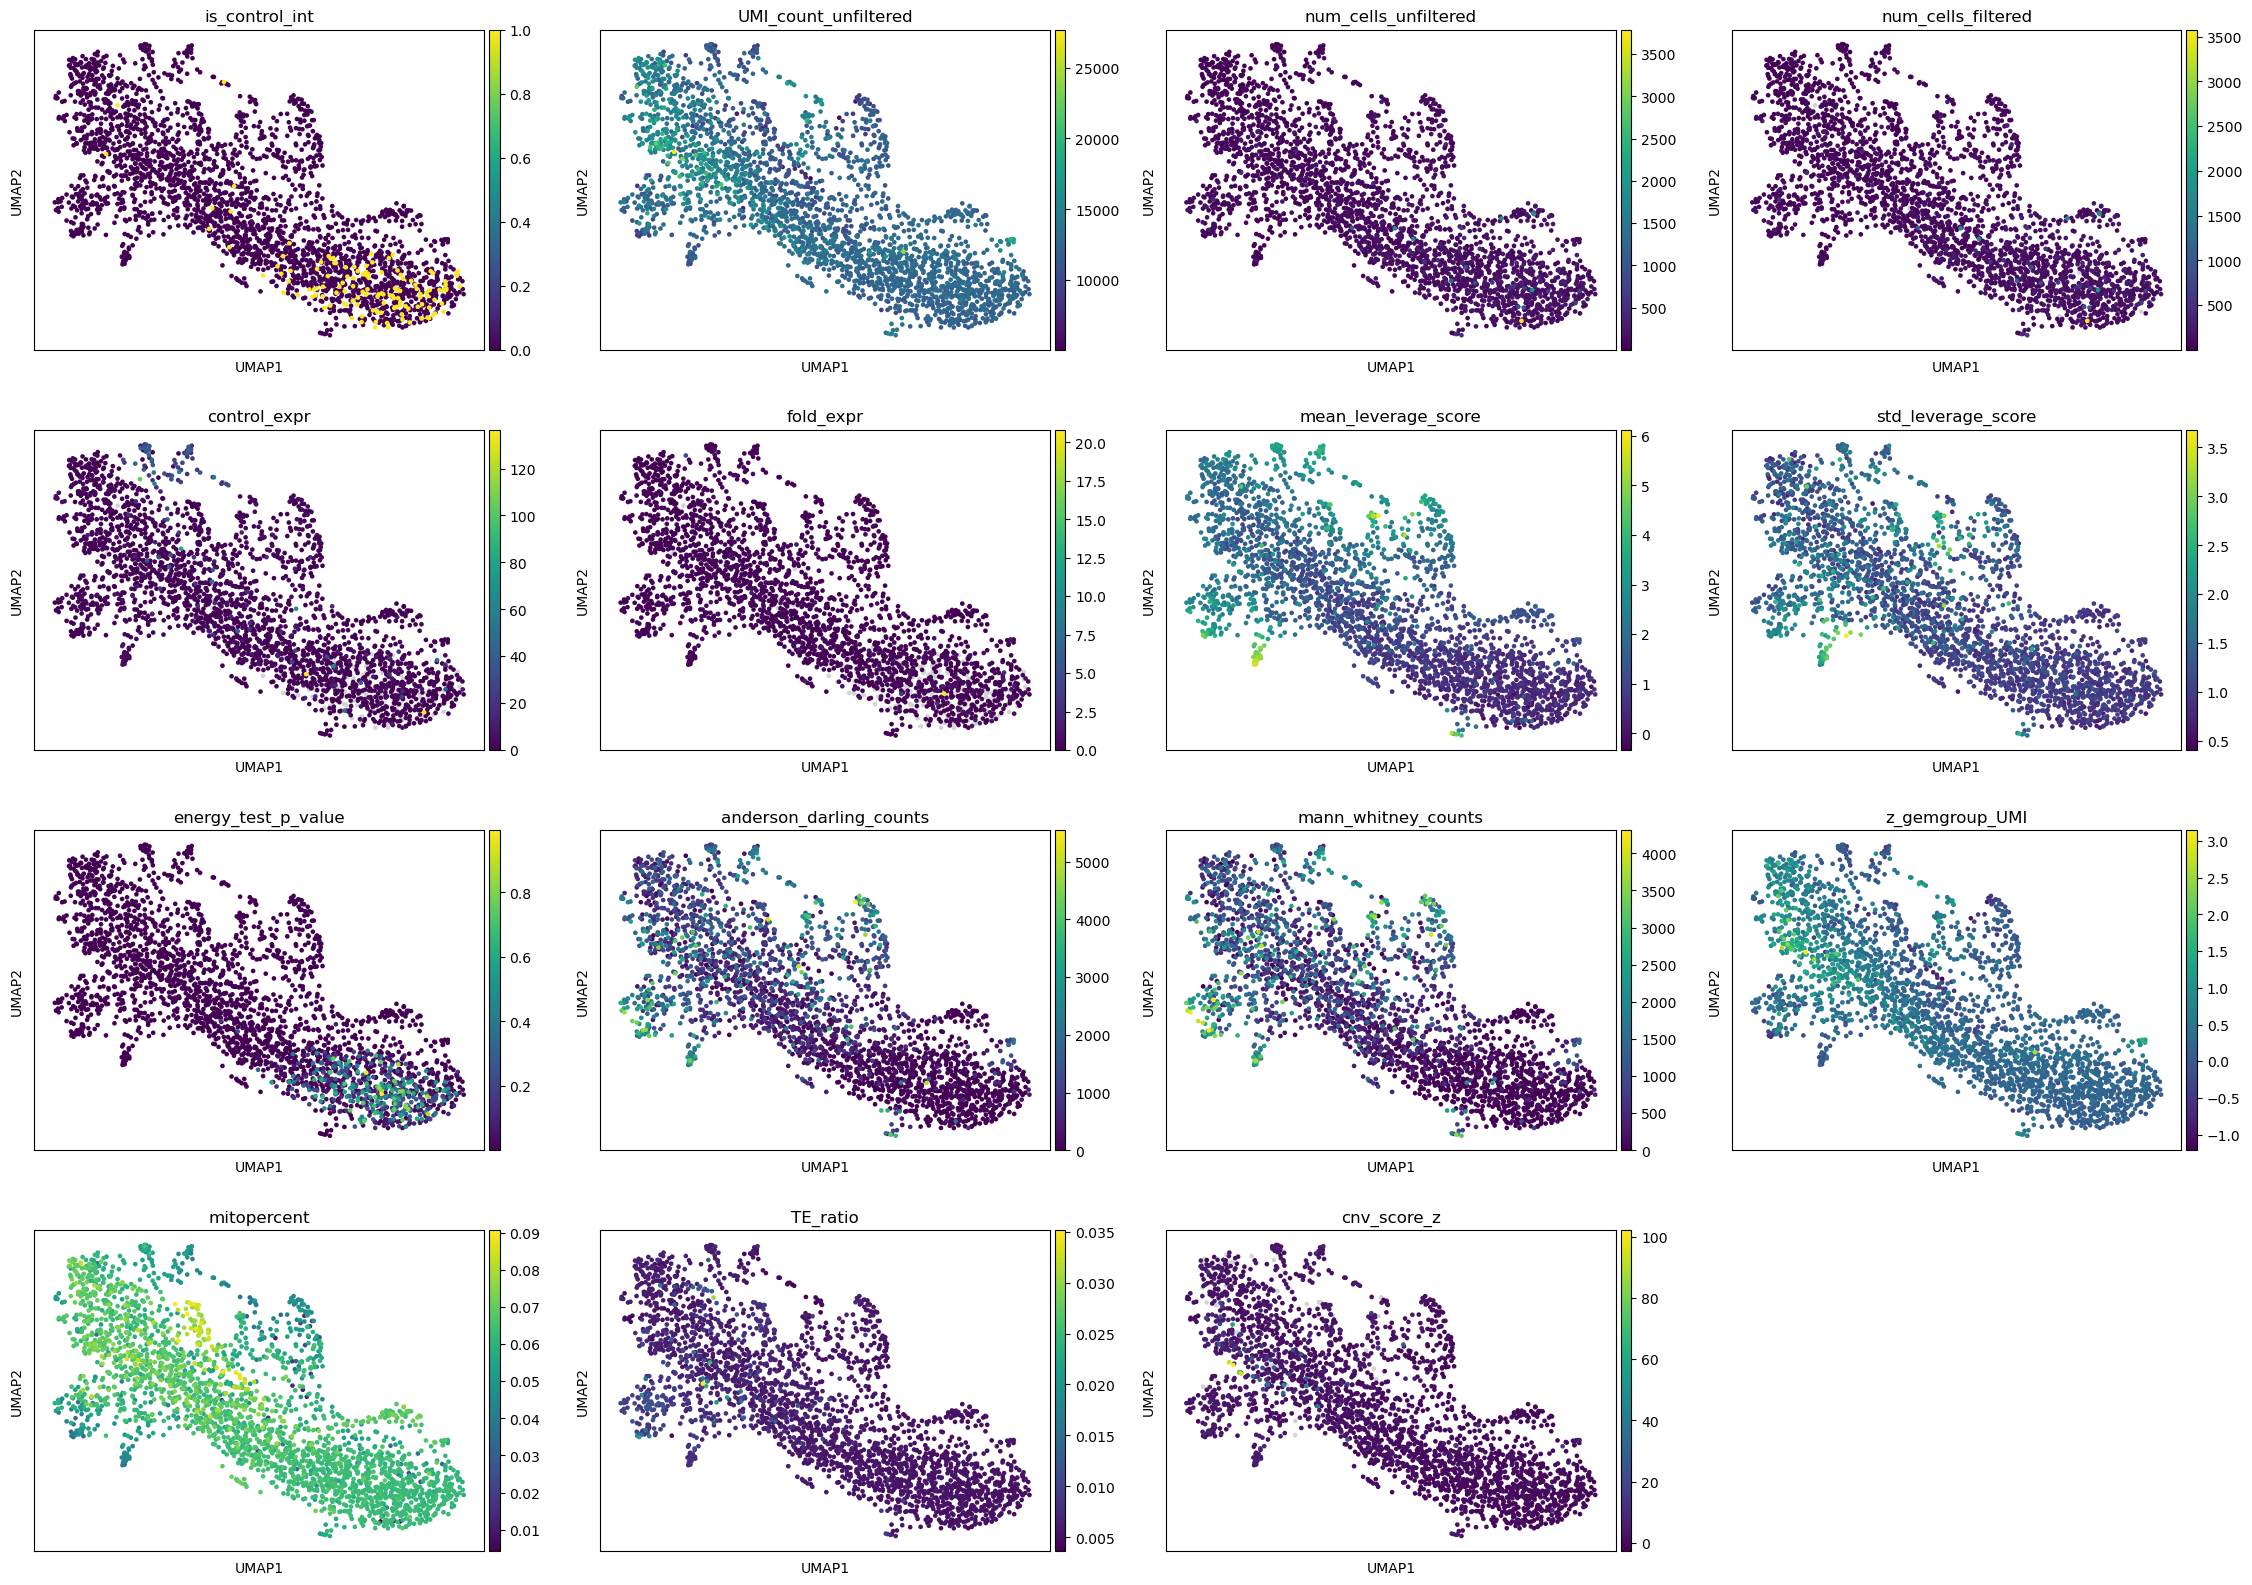

In [22]:
plt.rcParams['figure.figsize'] = [6, 4.5]
sc.pl.umap(pseudobulk, color = [
    "is_control_int",
    'UMI_count_unfiltered', 'num_cells_unfiltered', 'num_cells_filtered',
       'control_expr', 'fold_expr', 
       'mean_leverage_score', 'std_leverage_score', 'energy_test_p_value',
       'anderson_darling_counts', 'mann_whitney_counts', 'z_gemgroup_UMI',
       'mitopercent', 'TE_ratio', 'cnv_score_z',
])
# Will ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
pseudobulk.obs["fake_cluster"]="all_one_cluster"
pseudobulk.obs.fake_cluster = pseudobulk.obs.fake_cluster.astype("category")
pseudobulk.uns["fake_cluster_colors"] = ['#1f77b4']

### Data reduction/QC

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

In [23]:
perturbed_genes = set(list(pseudobulk.obs['perturbation'].unique())).difference(controls)
perturbed_and_measured_genes = perturbed_genes.intersection(pseudobulk.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(pseudobulk.var.index)
genes_keep = pseudobulk.var.index[pseudobulk.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
pseudobulk_orig = pseudobulk.copy()
print("This many genes were perturbed:")
print(len(perturbed_genes))
print("These genes were perturbed but not measured:")
print(len(perturbed_but_not_measured_genes))
print("This many variable genes will be kept and used by CO:")
print(len(genes_keep))

This many genes were perturbed:
2393
These genes were perturbed but not measured:
311
This many variable genes will be kept and used by CO:
3561


In [24]:
# final form, ready to save
pseudobulk = pseudobulk_orig[:,list(genes_keep)]
pseudobulk.uns["perturbed_and_measured_genes"]     = list(perturbed_and_measured_genes)
pseudobulk.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)
pseudobulk = ingestion.describe_perturbation_effect(pseudobulk, "knockdown")

In [25]:
os.makedirs(f"perturbations/{dataset_name}", exist_ok = True)
pseudobulk.write_h5ad(f"perturbations/{dataset_name}/test.h5ad")